# Week 16 Scratch Paper and Notes

## Imports

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# SciKit Learn Imports
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Statsmodel Imports
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data

In [2]:
cars = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRHn-VvsM6-rRjBdkV-AhjPmVai2CrlCxpEYe8Mmtk1wsS5sGEft-5nJTk0V99Tw-hDLLgARISU5-d_/pub?output=csv"
house = "https://docs.google.com/spreadsheets/d/e/2PACX-1vTiitWN7DnJMRDcRvMKL3_xu5Y0fl2u5J2vWOrJOcOy95ZiBulg5HqMftWWeiYFYYNHMuVPDWT_vxVc/pub?output=csv"

# Linear Regression Redux
Linear models are NOT the most accurate models but they are highly interpretable which makes them ideally suited for when we want to extract insights more than making accurate predictions.

Strengths:
- Simplicity: easy to read/understand.
- Coefficients tell us how the change in one variable effects the target.
- A 'glass box' when compared to the 'black box' of neural networks.

Weaknesses:
- Relatively 'dumb' model. Relationships between variables are simple.
- Not all linear regression coefficients are made equal. 


# Intro to Statsmodels
Statsmodels provides additional implementations of models that we have used in scikit-learn. Specifically it provides a more powerful version of linear regression.

[statsmodels documentation](https://www.statsmodels.org/stable/index.html)

Advantages of Statsmodels
- Summary view that provides additional information.
- Functions to help determine the best model
- Also great for time series analysis, advanced hypothesis testing, anomaly detection.

Disadvantages of Statsmodels
- documentation is not as detailed or user-friendly
- argument names are not intuitive
- different syntax than scikit learn and other ML packages.

## Preprocessing General
Refresher of sklearn preprocessing steps. Many of these will still be used with statsmodels

In [3]:
# Load Data
df = pd.read_csv(cars)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    int64  
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   model year    392 non-null    int64  
 7   origin        392 non-null    int64  
 8   car name      392 non-null    object 
dtypes: float64(3), int64(5), object(1)
memory usage: 27.7+ KB


In [4]:
# check for null and duplicates
print(f'dupes: {df.duplicated().sum().sum()}')
print(f'NAs: {df.isna().sum().sum()}')

dupes: 0
NAs: 0


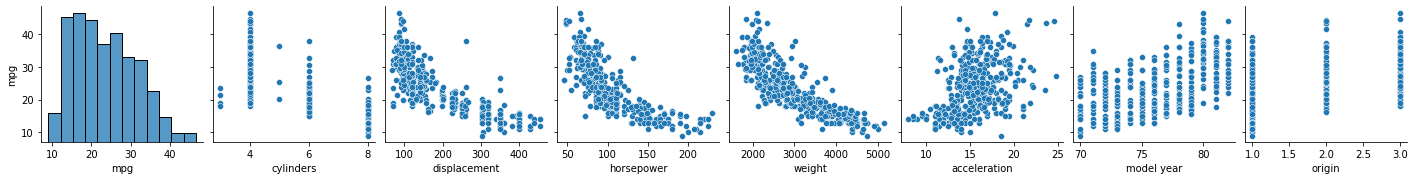

In [5]:
# Quick EDA for cols related to the target
sns.pairplot(df,y_vars='mpg');

In [6]:
# Apply map to the origin column
origin_map = {1:'NA', 2:'EU', 3:'AS'}
df['origin'] = df['origin'].replace(origin_map)
df['origin'].value_counts()

NA    245
AS     79
EU     68
Name: origin, dtype: int64

In [7]:
# Assign target (y) and features (X)
np.random.seed(321)

y = df['mpg'].copy()
X = df.drop(columns = ['mpg', 'car name']).copy()

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 321)
X_train.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin
295,5,183.0,77,3530,20.1,79,EU
214,4,98.0,68,2045,18.5,77,AS
48,4,122.0,86,2220,14.0,71,NA
302,4,91.0,69,2130,14.7,79,EU
160,6,258.0,110,3730,19.0,75,NA


In [8]:
# Make column selectors
cat_sel = make_column_selector(dtype_include='object')
num_sel = make_column_selector(dtype_include='number')

cat_cols = cat_sel(X_train)
num_cols = num_sel(X_train)

In [9]:
cat_pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse = False))

num_pipe = make_pipeline(SimpleImputer(strategy = 'mean'))

preprocessor = make_column_transformer((cat_pipe, cat_sel),
                                       (num_pipe, num_sel),
                                       remainder = 'passthrough')

## Preprocessing for Statsmodels
- Statsmodels cannot combined a column transformer and the model.
- Will haveto use our column transformer to generate processed x variables which will be used for modeling in statsmodels.

In [10]:
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f5d759afed0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f5d7593d910>)])

In [11]:
pd.DataFrame(preprocessor.transform(X_train).round(3))

,0,1,2,3,4,5,6,7,8
0,0.0,1.0,0.0,5.0,183.0,77.0,3530.0,20.1,79.0
1,1.0,0.0,0.0,4.0,98.0,68.0,2045.0,18.5,77.0
2,0.0,0.0,1.0,4.0,122.0,86.0,2220.0,14.0,71.0
3,0.0,1.0,0.0,4.0,91.0,69.0,2130.0,14.7,79.0
4,0.0,0.0,1.0,6.0,258.0,110.0,3730.0,19.0,75.0
...,...,...,...,...,...,...,...,...,...
289,0.0,0.0,1.0,6.0,258.0,95.0,3193.0,17.8,76.0
290,0.0,1.0,0.0,4.0,141.0,71.0,3190.0,24.8,79.0
291,0.0,0.0,1.0,8.0,350.0,155.0,4360.0,14.9,79.0
292,0.0,0.0,1.0,6.0,198.0,95.0,3102.0,16.5,74.0


### Categorical Feature Names

In [12]:
# create an empty list to recapture our features
final_features = []

In [13]:
preprocessor.named_transformers_['pipeline-1']

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='MISSING', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [14]:
# Option A: slice out the name of the object from the pipeline.named_steps
preprocessor.named_transformers_['pipeline-1'].named_steps

{'onehotencoder': OneHotEncoder(handle_unknown='ignore', sparse=False),
 'simpleimputer': SimpleImputer(fill_value='MISSING', strategy='constant')}

In [15]:
ohe_step = preprocessor.named_transformers_['pipeline-1'].named_steps['onehotencoder']
ohe_step

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [16]:
# Option B use integer-based slicing on the pipeline itself.
ohe_step = preprocessor.named_transformers_['pipeline-1'][-1]
ohe_step

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [17]:
# Use Get Feature Names Out to retrieve names from the OHE object
cat_features = ohe_step.get_feature_names_out(cat_cols)
cat_features

array(['origin_AS', 'origin_EU', 'origin_NA'], dtype=object)

In [18]:
# Add features to final feature list
final_features.extend(cat_features)
final_features

['origin_AS', 'origin_EU', 'origin_NA']

### Numeric Features Names

In [19]:
# Num cols previously pulled out by our selector. These were not changed/modified by our pipelien
num_cols

['cylinders',
 'displacement',
 'horsepower',
 'weight',
 'acceleration',
 'model year']

In [20]:
final_features.extend(num_cols)
final_features

['origin_AS',
 'origin_EU',
 'origin_NA',
 'cylinders',
 'displacement',
 'horsepower',
 'weight',
 'acceleration',
 'model year']

## Transform Using PreProcessor and Feature Names


In [21]:
# Transform X_train into processed DataFrame
X_train_processed = pd.DataFrame(preprocessor.transform(X_train),
                                           columns = final_features,
                                           index = X_train.index)

X_train_processed.head()

,origin_AS,origin_EU,origin_NA,cylinders,displacement,horsepower,weight,acceleration,model year
295,0.0,1.0,0.0,5.0,183.0,77.0,3530.0,20.1,79.0
214,1.0,0.0,0.0,4.0,98.0,68.0,2045.0,18.5,77.0
48,0.0,0.0,1.0,4.0,122.0,86.0,2220.0,14.0,71.0
302,0.0,1.0,0.0,4.0,91.0,69.0,2130.0,14.7,79.0
160,0.0,0.0,1.0,6.0,258.0,110.0,3730.0,19.0,75.0


In [22]:
# Transform X_test. ** REMEMBER do NOT fit on X_test**
X_test_processed = pd.DataFrame(preprocessor.transform(X_test),
                                columns = final_features,
                                index = X_test.index)
X_test_processed.head()

,origin_AS,origin_EU,origin_NA,cylinders,displacement,horsepower,weight,acceleration,model year
58,0.0,1.0,0.0,4.0,97.0,54.0,2254.0,23.5,72.0
234,0.0,0.0,1.0,4.0,140.0,89.0,2755.0,15.8,77.0
300,0.0,0.0,1.0,4.0,105.0,70.0,2150.0,14.9,79.0
278,0.0,0.0,1.0,6.0,231.0,115.0,3245.0,15.4,79.0
321,0.0,0.0,1.0,4.0,156.0,105.0,2800.0,14.4,80.0


### Adding a Constant
OLS model will NOT automatically include a constant/intercept in its linear equation.
- We need to include a column that has a constant value.
- statsmodels has a function sm.add_constant that adds a column named 'const' and fills it with 1.


In [23]:
# By default sm.add_constant adds the 'const' column to the beginning (prepend).
# We can add it to the back by including prepend=False

sm.add_constant(X_train_processed, prepend=False).head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,origin_AS,origin_EU,origin_NA,cylinders,displacement,horsepower,weight,acceleration,model year,const
295,0.0,1.0,0.0,5.0,183.0,77.0,3530.0,20.1,79.0,1.0
214,1.0,0.0,0.0,4.0,98.0,68.0,2045.0,18.5,77.0,1.0
48,0.0,0.0,1.0,4.0,122.0,86.0,2220.0,14.0,71.0,1.0
302,0.0,1.0,0.0,4.0,91.0,69.0,2130.0,14.7,79.0,1.0
160,0.0,0.0,1.0,6.0,258.0,110.0,3730.0,19.0,75.0,1.0


In [24]:
# Overwrite dataframes to icnlude constant
X_train_processed = sm.add_constant(X_train_processed, prepend=False)
X_test_processed = sm.add_constant(X_test_processed, prepend=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


# Statsmodels vs sklearn (Linear Regression)


## Sklearn Refresher

In [25]:
# Instantiate the Model
# Fit intercept not typically used... but because we hvae a constant column we need to set it to False
model = LinearRegression(fit_intercept = False)

In [26]:
# Fit the Model
# 2 notable differences... fit not saved as a variable, X_train is first and y_train is second.
model.fit(X_train_processed, y_train)

LinearRegression(fit_intercept=False)

In [27]:
# Get preds for evaluation
train_preds = model.predict(X_train_processed)
test_preds = model.predict(X_test_processed)

In [28]:
# Find r-squared value
print('Training r2: ', round(r2_score(y_train, train_preds),3))
print('Test r2: ', round(r2_score(y_test, test_preds),3))

# Fine MSE
print('Training MSE: ', round(mean_squared_error(y_train, train_preds), 3))
print('Test MSE: ', round(mean_squared_error(y_test, test_preds), 3))

Training r2:  0.829
Test r2:  0.8
Training MSE:  10.753
Test MSE:  10.896


## Fitting and OLS in statsmodels
When instantiating the OLS model in statsmodels you INCLUDE y_train and x_train
- Note y is first (unlike sklearn)

In [29]:
# Instantiate the model...
# hasconst = True is default and could be dropped...
model = sm.OLS(y_train, X_train_processed, hasconst = True)

In [30]:
# Fit the model.
# Note variables do NOT need to be provided
# Note that you have to save out the variable
results = model.fit()

In [31]:
# Evaluate using summary()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     172.3
Date:                Fri, 13 May 2022   Prob (F-statistic):          1.89e-104
Time:                        03:06:10   Log-Likelihood:                -766.33
No. Observations:                 294   AIC:                             1551.
Df Residuals:                     285   BIC:                             1584.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
origin_AS       -3.1274      1.400     -2.234   

## TWO Versions of OLS
Important to note there is another version of OLS available in the formulat API
- import statsmodels.formula.api as smf

careful when googling documentation or help that you have the correct OLS (sm.OLS) not the formulas OLS (smf.OLS)

# Interpreting Model Summary

- Top right: gives us our models performance metrics
 - R-Squared: same as sklearn r2_score
 - Adjsuted R-Squared: modified to prevent artificially high R-squared values 
- Middle Table: 'Coef column' sees the coefficients for each variable
 - if it goes up 1 how much does the target change
- P>[t] column:
 - p-value testing the $h_0$ that the coefficient for the column should be removed.. 
 -if p-value is >.05 then our model would be better with it removed.


In [32]:
model = sm.OLS(y_train, X_train_processed, hasconst = True)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     172.3
Date:                Fri, 13 May 2022   Prob (F-statistic):          1.89e-104
Time:                        03:06:10   Log-Likelihood:                -766.33
No. Observations:                 294   AIC:                             1551.
Df Residuals:                     285   BIC:                             1584.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
origin_AS       -3.1274      1.400     -2.234   

## Limitations of Model Summary
Note that this method fits the data so we cannot do this same process on the test set. 

We can get our test preds using the results.predict()
- NOTE this is a callback to the results generated by fitting the training set.

In [33]:
# Get Test Preds
test_preds = results.predict(X_test_processed)

In [34]:
# Use sklearn r2_score to evaluate the model on test data
print('Testing r2:', r2_score(y_test, test_preds))

Testing r2: 0.8004114047965174


## Using Sklearn Evaluation Functions with Statsmodels

In [35]:
## Instantiate/Fit an OLS model
model = sm.OLS(y_train,X_train_processed)
result = model.fit()

## Use the result (not the model) to get test preds
test_preds = result.predict(X_test_processed)

In [36]:
# Get evaluation metrics
test_r2 = r2_score(y_test, test_preds)
test_mse = mean_squared_error(y_test, test_preds)

In [37]:
# Use fstring to print results
print(f'The testing r-square value is {test_r2:.3f} \nThe testing mean squared error is {test_mse:.3f}.')

The testing r-square value is 0.800 
The testing mean squared error is 10.896.


F-strings are a great way to make reproducible / easy-to-read code to display our results from Statsmodels.

#Linear Regression Assumptions
There are four assumptions that need to be met in order to trust our linear model:
- Linearity: Input features have a linear relationship with the target
 - We want a linear pattern to the scatter plot between our feature and target.
- Independence of Features: features are not strongly related to one another
 - data that is multicollinear has multiple features that are linearly correlated to each other and make it difficult to trust the oefficients are magnifying our Target and not each other.
- Normality: models residuals are approximately normally distributed
 - Normally distributed residuals mean that the residuals are due to random variablity in the data.
- Homoscedasticity: models residuals have equal variance accross all predictions
 - No pattern in the residuals that could be the result of another factor

Residual: error or how wrong our model was. (residual = y_true - y_pred).

## Extended Example
linear regression on a housing data set while checking the assumptions listed above.

In [38]:
df = pd.read_csv(house)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          5000 non-null   int64  
 1   bedrooms       5000 non-null   int64  
 2   bathrooms      5000 non-null   float64
 3   sqft_living    5000 non-null   int64  
 4   sqft_lot       5000 non-null   int64  
 5   floors         5000 non-null   float64
 6   waterfront     5000 non-null   int64  
 7   sqft_above     5000 non-null   int64  
 8   sqft_basement  5000 non-null   int64  
 9   yr_built       5000 non-null   int64  
 10  yr_renovated   5000 non-null   int64  
 11  zipcode        5000 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 468.9 KB


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode
0,1100000,2,1.75,2050,11900,1.0,0,2050,0,1950,0,98004
1,430000,3,1.50,1690,9708,1.5,0,1690,0,1954,0,98006
2,2150000,3,2.75,3470,9610,3.0,1,3470,0,1989,2000,98034
3,336000,4,2.50,2530,8169,2.0,0,2530,0,1993,0,98003
4,649500,3,3.00,3730,383328,1.5,0,2230,1500,1990,0,98038


In [39]:
# zipcode should be categorical vice numeric
df['zipcode'] = df['zipcode'].astype(str)

In [40]:
#check for nulls
df.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
dtype: int64

###Assumption 1: Linearity
Easist to check via visualization

In [41]:
num_sel = make_column_selector(dtype_include = 'number')
cols = num_sel(df.drop(columns = 'price')) #drop price as it is the target
len(cols)

10

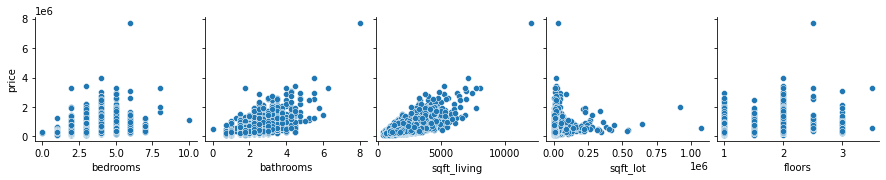

In [42]:
# knowing there are 10 columns we can split our pairplot into two groups of 5.
sns.pairplot(df, y_vars = 'price', x_vars = cols[:5])

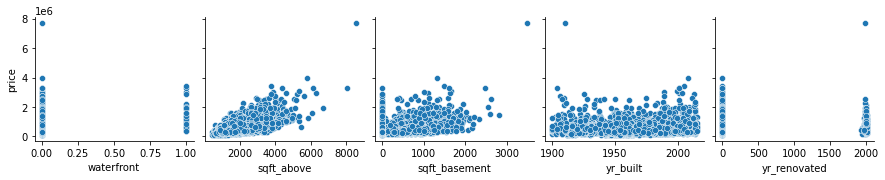

In [43]:
sns.pairplot(df, y_vars = 'price', x_vars = cols[5:])

**This would be easier with a colored line**... so lets make that happen... 

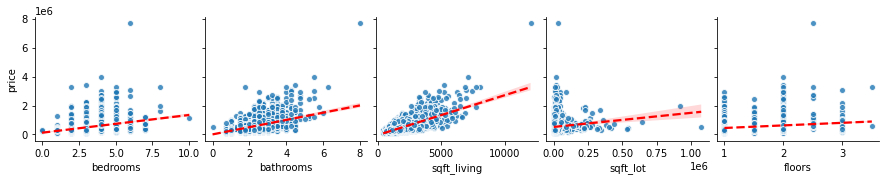

In [44]:
sns.pairplot(df, y_vars = 'price', x_vars = cols[:5], kind = 'reg',
             plot_kws = dict(line_kws = {'color':'red', 'ls':'--'},
                                         scatter_kws={'edgecolor':'white','lw':1}));

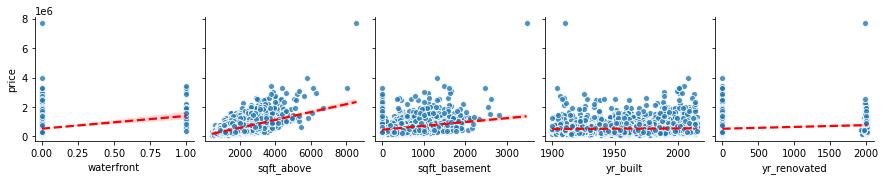

In [45]:
sns.pairplot(df, y_vars = 'price', x_vars = cols[5:], kind = 'reg',
             plot_kws = dict(line_kws = {'color':'red', 'ls':'--'},
                                         scatter_kws={'edgecolor':'white','lw':1}));

Based on the above plots it does not appear that yr_built and sqft_lot have a linear relationship with price. They can be dropped

In [46]:
df.drop(columns = ['sqft_lot', 'yr_built'], inplace = True)

### Assumption 2: Independent Features (No Multicollinearity)
We can use correlation to find which features are highly correlated (above +0.8 or below -0.8)

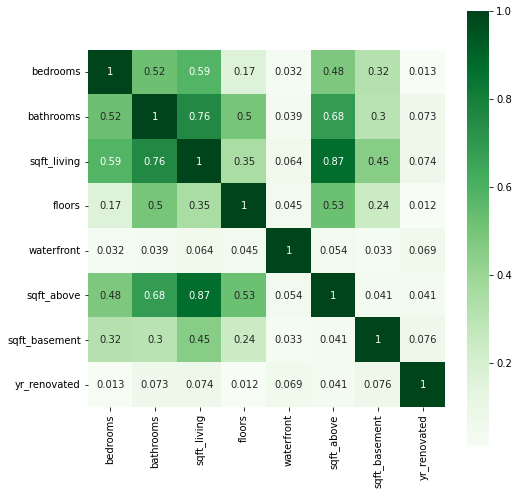

In [47]:
corr = df.drop(columns = 'price').corr().abs()

fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(corr, cmap = 'Greens', annot = True, square = True)

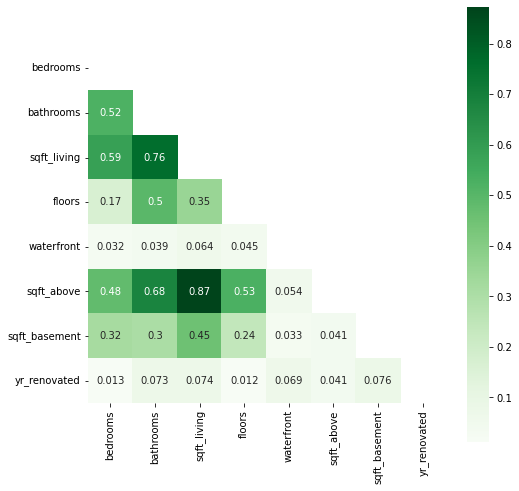

In [48]:
# Advanced trick! Add a mask to block the duplicate values in the top right...
mask = np.triu(np.ones_like(corr))

fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(corr, annot = True, cmap = 'Greens', square = True, mask=mask);

Looking at the heatmap above we can see that sqft_above and sqft_livng have a highly correlated relationship (0.87)

We will drop one of these two based on:
- do either have multicolinearity with another feature?
- which of the two is more strongly correlated with price? 

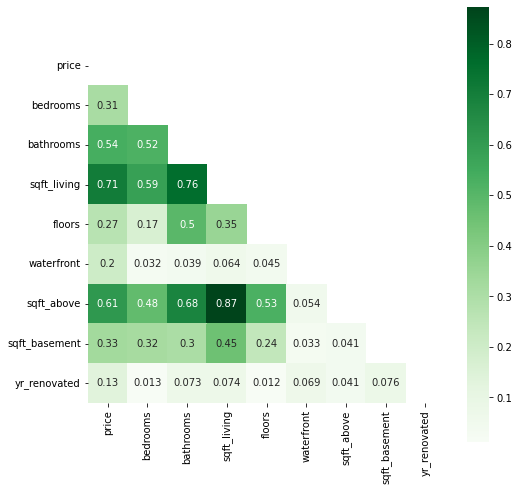

In [49]:
corr = df.corr().abs()
mask = np.triu(np.ones_like(corr))

fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(corr, annot = True, cmap = 'Greens', square = True, mask=mask);

sqft_living has a higher correlation with price than sqft_above. For this reason we will keep living vs above.

In [50]:
df.drop(columns = 'sqft_above', inplace = True)

### Run the Model
Yes you read this right... assumptions 3, 4 are on residuals so can't be checked until AFTER we run the model.

In [51]:
y = df['price'].copy()
X = df.drop(columns = 'price').copy()
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 321)

X_train.head()

,bedrooms,bathrooms,sqft_living,floors,waterfront,sqft_basement,yr_renovated,zipcode
1344,3,1.75,1850,1.0,0,0,0,98045
1282,3,2.25,1870,1.0,0,430,0,98011
681,3,1.75,1750,1.5,0,520,0,98117
3851,3,1.00,1170,1.0,0,0,0,98125
3564,2,1.50,901,3.0,0,0,0,98115


In [52]:
cat_sel = make_column_selector(dtype_include='object')
cat_cols = cat_sel(X_train)
cat_cols

['zipcode']

In [53]:
num_sel = make_column_selector(dtype_include='number')
num_cols = num_sel(X_train)
num_cols

['bedrooms',
 'bathrooms',
 'sqft_living',
 'floors',
 'waterfront',
 'sqft_basement',
 'yr_renovated']

In [54]:
cat_pipe = make_pipeline(SimpleImputer(strategy = 'constant', fill_value = 'MISSING'),
                         OneHotEncoder(sparse = False, handle_unknown='ignore'))
num_pipe = make_pipeline(SimpleImputer())

processor = make_column_transformer((num_pipe, num_cols),
                                    (cat_pipe, cat_cols),
                                    remainder = 'passthrough')
processor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['bedrooms', 'bathrooms', 'sqft_living',
                                  'floors', 'waterfront', 'sqft_basement',
                                  'yr_renovated']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['zipcode'])])

In [55]:
processor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['bedrooms', 'bathrooms', 'sqft_living',
                                  'floors', 'waterfront', 'sqft_basement',
                                  'yr_renovated']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['zipcode'])])

In [56]:
final_features = []
final_features.extend(num_cols)

cat_features = processor.named_transformers_['pipeline-2'][-1].get_feature_names_out(cat_cols)
final_features.extend(cat_features)

In [57]:
X_train_df = pd.DataFrame(processor.transform(X_train),
                          columns = final_features,
                          index = X_train.index)
X_train_df = sm.add_constant(X_train_df, prepend = False)

X_train_df.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,bedrooms,bathrooms,sqft_living,floors,waterfront,sqft_basement,yr_renovated,zipcode_98001,zipcode_98002,zipcode_98003,...,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,const
1344,3.0,1.75,1850.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1282,3.0,2.25,1870.0,1.0,0.0,430.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
681,3.0,1.75,1750.0,1.5,0.0,520.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3851,3.0,1.00,1170.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3564,2.0,1.50,901.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [58]:
X_test_df = pd.DataFrame(processor.transform(X_test),
                          columns = final_features,
                          index = X_test.index)
X_test_df = sm.add_constant(X_test_df, prepend = False)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [59]:
model = sm.OLS(y_train, X_train_df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     170.6
Date:                Fri, 13 May 2022   Prob (F-statistic):               0.00
Time:                        03:06:34   Log-Likelihood:                -50424.
No. Observations:                3750   AIC:                         1.010e+05
Df Residuals:                    3673   BIC:                         1.015e+05
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -4.194e+04   3959.240    -10.592

### Assumption 3: Normality
Using a Q-Q plot which shows deviation from the norm. Better than scipy's normaltest because it allows us to interpret more than if we just took the yes/no approach.

In [60]:
# residuals conveniently saved in the OLS model under resid
resid = results.resid
resid.head()

1344    -20242.467226
1282      1016.673278
681     -51423.211967
3851    103498.661493
3564    116338.934543
dtype: float64

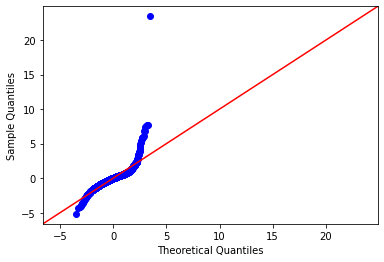

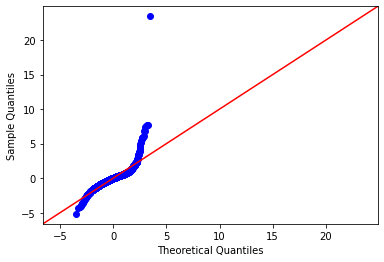

In [61]:
sm.graphics.qqplot(resid, line = '45', fit =True)

- The y-axis is our residuals compared to the normal distribution on the x-axis.- The red line is what we would expect to see if everything was normal.

Based on the above Q-Q plot we are violating the assumption ofnormality. Our left tail is acceptable but our right tail is not and has one major outlier.

We will return to fix this later.

### Assumption 4: Homoscedasticity
We want to visualize our residuals across the range of values it predicted
- create a residual plot with predictions on the x-axis and residuals on the y-axis. 

We want the resulting plot to be spread out with no real shape

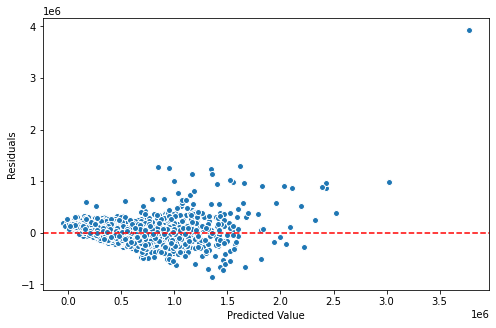

In [62]:
y_pred = results.predict(X_train_df)
resid = y_train - y_pred

fig, ax = plt.subplots(figsize = (8,5))
ax.scatter(y_pred, resid, ec='white',lw=1)
ax.axhline(0, color = 'red', ls = '--')
ax.set(ylabel='Residuals', xlabel='Predicted Value');

Interpreting a residual plot
- We want to see our points spread out. No clear pattern.
 - Variablity is okay
 - Do NOT want to see a cone shape

 Looking at our residual plot we can see a cone shape with a tight cluster on the left that continues to spread to the right. 

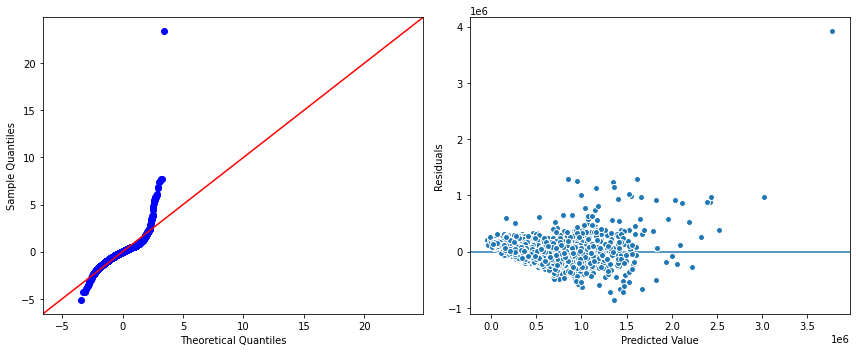

In [63]:
## For future use... a function that will spit out our Q-Q plot and Residual plot all at once!!! 
def evaluate_ols(result,X_train_df, y_train):
    """Plots a Q-Q Plot and residual plot for a statsmodels OLS regression.
    """
    
    ## save residuals from result
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    
    ## Normality 
    sm.graphics.qqplot(resid,line='45',fit=True,ax=axes[0]);
    
    ## Homoscedasticity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=1)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()
    
evaluate_ols(results,X_train_df, y_train)

### Diagnosing the model
Now lets interpret the above model summary/evaluation visuals.
-The resiudals look to have some problems. At least one extreme value on the right side is pulling everything. Lets remove outliers and see what happens.

In [64]:
# get zscore
scaler = StandardScaler()
z_price = scaler.fit_transform(y_train.values.reshape(-1,1))
z_price

array([[-0.40517352],
       [-0.30686833],
       [-0.02613678],
       ...,
       [-0.76749839],
       [-0.91214746],
       [-0.46977408]])

In [65]:
# flatten back into a pandas series
z_price = pd.Series(z_price.flatten(), index = y_train.index)
z_price

#can also use stats.zscore as an alternative here... 

1344   -0.405174
1282   -0.306868
681    -0.026137
3851   -0.334956
3564   -0.278781
          ...   
168     1.982238
1425    0.156570
3784   -0.767498
2847   -0.912147
4220   -0.469774
Length: 3750, dtype: float64

In [66]:
# Get a true/false index for is outlier..
idx_outliers = z_price>3
idx_outliers

1344    False
1282    False
681     False
3851    False
3564    False
        ...  
168     False
1425    False
3784    False
2847    False
4220    False
Length: 3750, dtype: bool

In [67]:
# how many outliers in y_train?
idx_outliers.sum()

63

In [68]:
# Cut the outliers out
y_train_cln = y_train[~idx_outliers]
X_train_cln = X_train_df[~idx_outliers]

One the outliers have been removed we need to know what data we are summarizing still.

In [69]:
print(f"Our model includes homes priced:")
print(f"- Greater than ${y_train_cln.min():,.2f}")
print(f"- Less than ${y_train_cln.max():,.2f}")

Our model includes homes priced:
- Greater than $82,000.00
- Less than $1,600,000.00


In [70]:
## Apply the same process on the test data

z_price_test = scaler.transform(y_test.values.reshape(-1,1))
z_price_test = pd.Series(z_price_test.flatten(), index=y_test.index)

idx_outliers_test = z_price_test > 3
idx_outliers_test.sum()

24

In [71]:
X_test_cln = X_test_df[~idx_outliers_test]
y_test_cln = y_test[~idx_outliers_test]

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     187.3
Date:                Fri, 13 May 2022   Prob (F-statistic):               0.00
Time:                        03:06:37   Log-Likelihood:                -48210.
No. Observations:                3687   AIC:                         9.657e+04
Df Residuals:                    3610   BIC:                         9.705e+04
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -1.972e+04   2814.752     -7.007

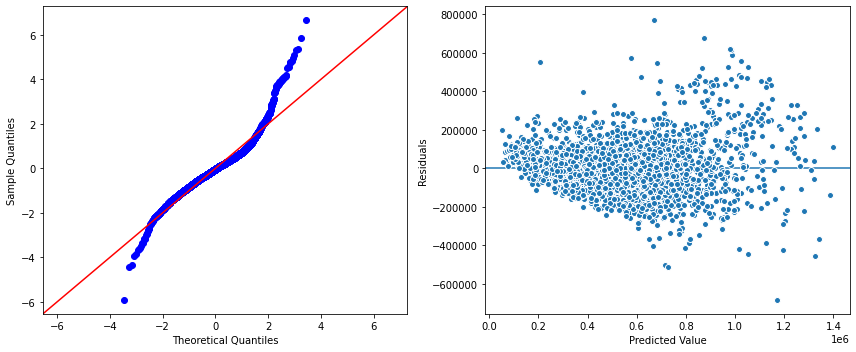

In [72]:
# Fit and diagnose the new model without outliers
model = sm.OLS(y_train_cln, X_train_cln)
results = model.fit()
print(results.summary())
evaluate_ols(results, X_train_cln, y_train_cln)

- Q-Q Plot: There is still some deviation away from the normal distribution (red line) at the tails but it is much better/acceptable
- Residual Plot: Residuals no longer show a cone pattern.

#### Remove columns w/ insignficant P-Values

In [73]:
p_vals = results.pvalues
p_vals[p_vals >.05]

zipcode_98024    0.186877
zipcode_98027    0.336972
zipcode_98034    0.126808
zipcode_98053    0.141641
zipcode_98074    0.161004
zipcode_98077    0.263280
zipcode_98118    0.103993
zipcode_98125    0.324225
zipcode_98126    0.527918
dtype: float64

The only values that are insignificant are a few of the zipcodes. HOWEVER, because these are the result of being OHE we can either remove all or none of the zipcodes. 
- The majority of our zipcodes ARE significant so we will choose to keep them.

### Run on the Test Data

R-Squared Test Score: 0.78


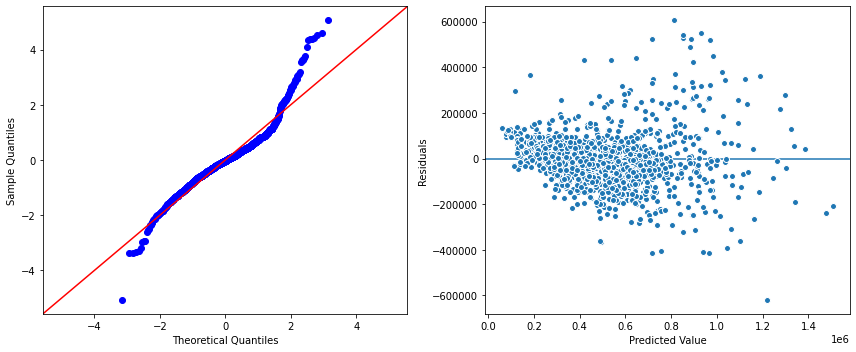

In [74]:
r2_test = r2_score(y_test_cln, results.predict(X_test_cln))
print(f"R-Squared Test Score: {r2_test:.2f}")
evaluate_ols(results, X_test_cln, y_test_cln)

# Using joblib to save a model
alternate to [pickling](https://docs.python.org/3/library/pickle.html)

In [75]:
## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train_cln,
         'y_train':y_train_cln,
         'X_test':X_test_cln,
         'y_test':y_test_cln,
          'Outlier Scaler':scaler,
          'Column Transformer':preprocessor,
         'OLS Results': result}

## Saving

In [76]:
## Save out joblib results
# import joblib
# joblib.dump(export, 'ols_results.joblib')

## Loading

In [77]:
## Load in joblib results
# import joblib
# loaded_data = joblib.load('ols_results.joblib')
# loaded_data.keys()

# Interpretting Coefficients
Coefficients are the m in the y = mx +b
- y: dependent variable
- m: coeff/slope
- x: independent variable (features)
- b: constant/intercept

We will start with our previously made model

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     187.3
Date:                Fri, 13 May 2022   Prob (F-statistic):               0.00
Time:                        03:09:52   Log-Likelihood:                -48210.
No. Observations:                3687   AIC:                         9.657e+04
Df Residuals:                    3610   BIC:                         9.705e+04
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms      -1.972e+04   2814.752     -7.007

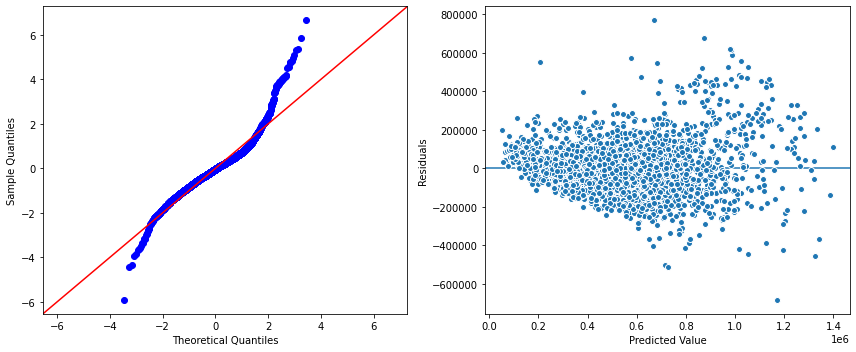

In [81]:
print(results.summary())
evaluate_ols(results, X_train_cln, y_train_cln)

## Interpretting Coeffs

Coefficients are stored in the .params attribute of the results variable

In [82]:
coeffs = results.params
coeffs

bedrooms         -19723.359525
bathrooms         28172.329800
sqft_living         207.233425
floors           -41138.398629
waterfront       418376.338039
                     ...      
zipcode_98178   -158056.037850
zipcode_98188   -185179.202932
zipcode_98198   -190653.807548
zipcode_98199    221153.926332
const            177606.752950
Length: 78, dtype: float64

In [85]:
# Splitting out zip codes for easier analysis 
zip_cols = coeffs.index.str.contains('zipcode')

coeffs_zip = coeffs.loc[zip_cols].copy()
coeffs_zip

zipcode_98001   -203278.840933
zipcode_98002   -204908.623666
zipcode_98003   -200571.992824
zipcode_98004    457266.881184
zipcode_98005    176257.225821
                     ...      
zipcode_98177     66476.390534
zipcode_98178   -158056.037850
zipcode_98188   -185179.202932
zipcode_98198   -190653.807548
zipcode_98199    221153.926332
Length: 70, dtype: float64

In [87]:
# Splitting out the non-zip coefficients 
coeffs_main = coeffs.loc[~zip_cols].copy()
coeffs_main

bedrooms         -19723.359525
bathrooms         28172.329800
sqft_living         207.233425
floors           -41138.398629
waterfront       418376.338039
sqft_basement       -73.783983
yr_renovated         24.836621
const            177606.752950
dtype: float64

These coefficients tell us that when we increase the value by 1 the target value will increase by the coefficient value

In [95]:
# By sorting we can see which will have the most/least (or negative) effect on the target
coeffs_main = coeffs_main.sort_values(ascending = False)
coeffs_main

waterfront       418376.338039
const            177606.752950
bathrooms         28172.329800
sqft_living         207.233425
yr_renovated         24.836621
sqft_basement       -73.783983
bedrooms         -19723.359525
floors           -41138.398629
dtype: float64

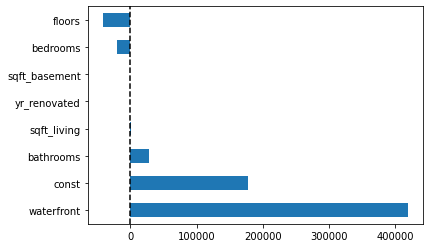

In [96]:
# Alternatively we can graph it
coeffs_main.plot(kind = 'barh')
plt.axvline(color = 'k', ls= '--');

In [97]:
## formatting our axis to match our dataframe floats
from matplotlib.ticker import StrMethodFormatter

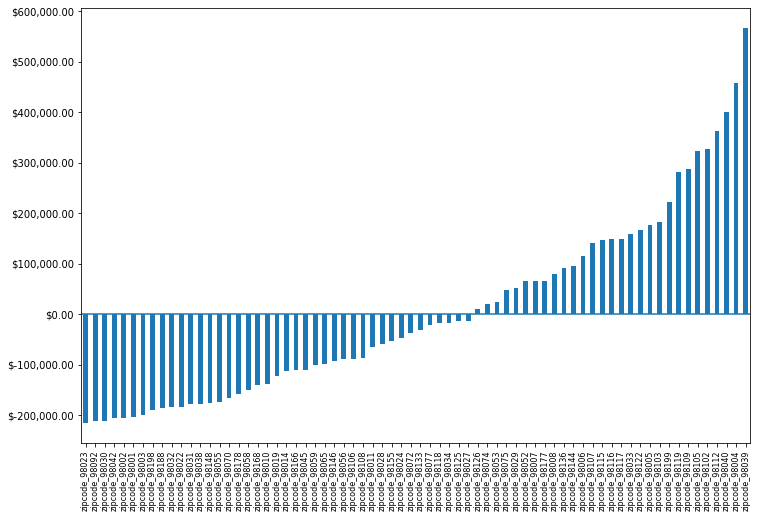

In [99]:
ax = coeffs_zip.sort_values().plot(kind='bar',figsize=(12,8))
ax.axhline()
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.2f}'))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,fontsize=8);